In [1]:
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
sys.path.append("neuroformer")

In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [3]:
from utils import set_seed
set_seed(25)

In [4]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

train_path = "/content/stimulus"
train_path = "/Users/antonis/projects/slab/neuroformer/OneCombo3/stimuli"
video_stack = [skimage.io.imread(train_path + vid) for vid in im_path]
print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

/Users/antonis/miniconda3/envs/transformer_exp/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


['/Users/antonis/projects/slab/neuroformer/OneCombo3/stimuli/Combined Stimuli 3-Movie3.tif', '/Users/antonis/projects/slab/neuroformer/OneCombo3/stimuli/Combined Stimuli 3-grating.tif', '/Users/antonis/projects/slab/neuroformer/OneCombo3/stimuli/Combined Stimuli 3-Movie2.tif']
im_sack size: torch.Size([5760, 1, 64, 112])


In [5]:
video_stack.shape

torch.Size([3, 640, 1, 64, 112])

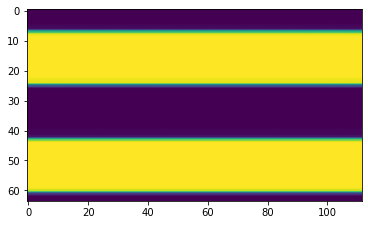

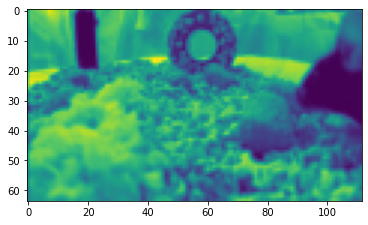

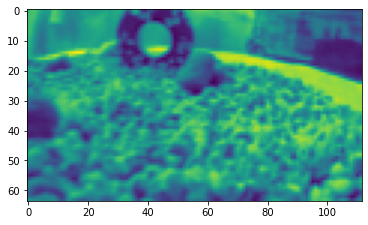

In [6]:
plt.figure()
plt.imshow(video_stack[0, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[1, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[2, 1, 0].permute(0, 1))

In [7]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/Users/antonis/projects/slab/neuroformer/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [8]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['Interval_dt'] = make_intervals(df, dt)
df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

In [9]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
# dt_range = range(int(window / dt) + 2)  # add first / last interval for SOS / EOS'
dt_range = range(int(window / dt) + 1)  # add first interval for SOS (0.0)'
n_dt = [round(dt * n, 2) for n in dt_range]
df['Time'] = df['Time'].round(3)

In [10]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
df.groupby(['Interval', 'Trial']).size().nlargest(100)

Interval  Trial
18.5      42       49
4.5       45       36
26.0      49       35
29.0      26       35
4.0       23       33
                   ..
          29       21
          33       21
4.5       22       21
7.0       13       21
7.5       7        21
Length: 100, dtype: int64

In [11]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 52
id_block_size = prev_id_block_size   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [12]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(3):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [13]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
single_batch = SpikeTimeVidData2(df[df['Trial'].isin([5])], None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 20449 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 5163 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 393 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 393 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
train: 2941, test: 729


In [14]:
def get_class_weights(dataset):
  dt = []
  id = []
  for x, y in dataset:
    id.extend([stoi['SOS']] + y['id'][:len(y['id']) - x['pad']].flatten().tolist() + [stoi['PAD']]) # -1 in pad to include PAD token
    dt.extend([stoi_dt[0]] + y['dt'][:len(y['dt']) - x['pad']].flatten().tolist() + [dataset.dt_max]) # -1 in pad to include PAD token

  id = pd.DataFrame(id)
  dt = pd.DataFrame(dt)

  id_freq = id.groupby([0]).size()
  dt_freq = dt.groupby([0]).size()

  id_ones = np.ones(dataset.id_population_size)
  dt_ones = np.ones(dataset.dt_population_size)

  id_ones[id_freq.index] = (1 / id_freq) * id_freq.max() / id_freq.max()
  dt_ones[dt_freq.index] = (1 / dt_freq) * dt_freq.max() / dt_freq.max()
  
  class_freq = dict()
  class_freq['id'] = torch.tensor(id_ones, dtype=torch.float32)
  class_freq['dt'] = torch.tensor(dt_ones, dtype=torch.float32)
  
  return class_freq 

class_weights = get_class_weights(train_dataset)

In [18]:
from model_perceiver import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=True,
                        n_layer=8, n_head=8, n_embd=256,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.2, im_drop=0.2)
model = GPT(mconf)
# model.load_state_dict(torch.load("/Users/antonis/Downloads/model_shuffle_perceiver_2.0_dt_0.05_eos_8_8_256.pt", map_location='cpu'))
model.load_state_dict(torch.load("/Users/antonis/projects/slab/neuroformer/OneCombo3/models/model_sim_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.pt", map_location='cpu'))

01/29/2022 19:43:26 - INFO - model_perceiver -   number of parameters: 3.358669e+07


<All keys matched successfully>

In [19]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_8_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_shuffle_8_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_81_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_83_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_dt_8_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_dt_8_8_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_dt_eos_8_8_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_2.0_dt_eos_8_8_256.pt"))
# model.load_state_dict(torch.load(f"/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt"))
# model.load_state_dict(torch.load(f"/content/drive/MyDrive/slab/models/OneCombo3/model_shuffle_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt"))


In [20]:
# loader = DataLoader(small_dataset, shuffle=False, pin_memory=False,
#                                   batch_size=1, num_workers=1)
# x, y = next(iter(loader))
# model = model.to('cpu')

# preds, features, loss = model(x, y)

In [ ]:
max_epochs = 400
batch_size = 32
shuffle = True

In [ ]:
from trainer import Trainer, TrainerConfig
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-01-21-14:18-e:19-b:239-l:4-h:2-ne:512-higher_order.pt"))
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"))

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=7e-5, 
                      num_workers=4, lr_decay=False, warmup_tokens=4e5, 
                      decay_weights=True, shuffle=shuffle,
                      final_tokens=len(train_dataset)*(block_size // 8) * (max_epochs),
                      clip_norm=3.0, grad_norm_clip=2.0,
                      dataset='higher_order', mode='predict',
                      block_size=train_dataset.block_size,
                      id_block_size=train_dataset.id_block_size,
                      show_grads=False, plot_raster=False,
                      ckpt_path=f"/Users/antonis/projects/slab/neuroformer/OneCombo3/models/model_weighted_shuffle:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")

trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
trainer.train()  

In [ ]:
loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)
                                  

In [ ]:
iterable = iter(loader)

In [ ]:
x, y = next(iterable)

In [ ]:
x['id']

In [ ]:
x['id'][:, :id_block_size - x['pad']]

In [ ]:
y['id']

In [ ]:
x['id']

In [ ]:
logits, _, _ = model(x, y)

In [ ]:
type(logits['id'])

In [ ]:
logits.keys()

In [37]:
""" Predict using TEST dataset """

from utils import predict_raster, predict_raster_resnet, predict_raster_enc_dec, predict_raster_recursive, predict_beam_search, predict_raster_recursive_time, predict_raster_recursive_time_auto, predict_beam_search_time, predict_raster_hungarian
from utils import set_plot_params
set_plot_params()
%matplotlib inline

loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# device = torch.cuda.current_device()
# model = model.to(device)
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-11:49-e:1-b:650-l:4-h:4-ne:256-higher_order.pt"))

""" 

To predict only neurons we pass <frame_end> so we see predictions only for Neurons 
If you want to also see frame_tokens, just pass <frame_end=0>

NOTE: 512 ID is the <end-of-sequence-id>. Right now, makes no difference if I include
it in loss, here it is included in loss and predictions.

"""
# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted = predict_raster(model, loader)

# true, predicted = predict_beam_search(model, loader, stoi, frame_end=0)
# true, predicted, true_timing = predict_raster_recursive(model, loader, stoi, sample=True, top_p=0.95, gpu=True, frame_end=0)
results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.65, top_p_t=0.65, frame_end=0, get_dt=True, gpu=False)

# true, predicted = predict_raster_hungarian(model, loader)
# true, predicted = predict_raster(model, loader, gpu=True)

# true_df = pd.DataFrame(true.numpy())
# predicted_df = pd.DataFrame(predicted.numpy())
# print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

100%|██████████| 729/729 [06:17<00:00,  1.93it/s]


In [44]:
whole_dataset = SpikeTimeVidData2(df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)

loader = DataLoader(whole_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.675, top_p_t=0.675, frame_end=0, get_dt=True, gpu=False)
                                  

Length: 25612 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52


100%|██████████| 3670/3670 [31:44<00:00,  1.93it/s]  


In [88]:
# results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.95, top_p_t=0.95, frame_end=0, get_dt=True, gpu=False)

pred_keys = ['pred', 'time_pred', 'trial', 'interval']
predicted_dict = {k: results[k] for k in results if k in pred_keys}
df_pred = pd.DataFrame(predicted_dict)
df_pred.rename({'pred':'ID', 'time_pred':'dt', 'trial':'Trial'}, axis=1, inplace=True)
df_pred['Time'] = df_pred['dt'] + df_pred['interval'] - 0.5
# df_true['time'] = df_true['dt'] + df_true['interval'] - 0.5

In [89]:
true_keys = ['true', 'time']
true_dict = {k: results[k] for k in results if k in true_keys}
df_true = pd.DataFrame(true_dict)
df_true.rename({'true':'ID', 'Time':'dt'}, axis=1, inplace=True)

In [90]:
# predicted_timing = [itos_dt[int(dt)] for dt in predicted_timing]
# df_pred = pd.DataFrame({'True':true, 'Predicted':predicted, 'Time':true_timing, 'Predicted_Time':predicted_timing})    # Time':test_data['Time']})
df_pred.to_csv(f"/Users/antonis/projects/slab/neuroformer/OneCombo3/inference/full_sim2__model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv")

In [ ]:
# df_pred = pd.read_csv("/content/drive/MyDrive/slab/predictions/model_dt_perceiver_83_4_256.csv")

In [ ]:
set_plot_params()

# from utils import set_plot_white
# set_plot_white


KeyError: 'dt'

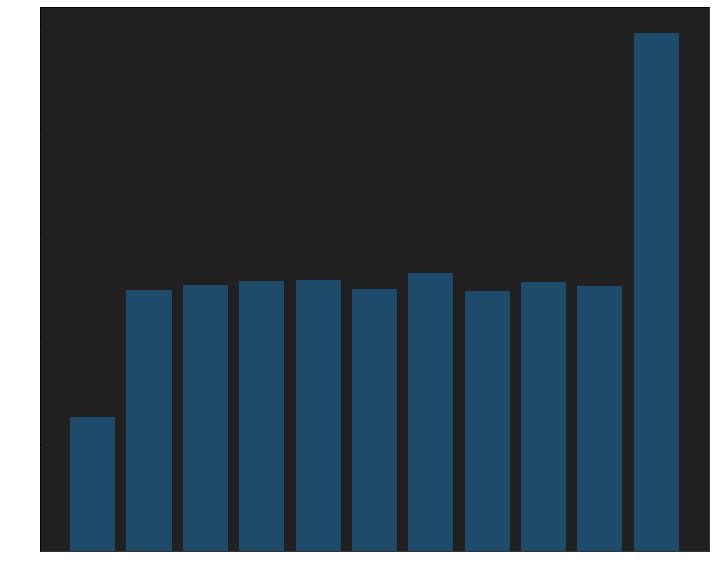

In [111]:
# df_dt = [y['dt'][:len(y['dt']) - (x['pad'])] for x, y in test_dataset]
plt.figure(figsize=(12,10))

# df_dt = df_true['time']
freq_dt_true = df_true.groupby(['time']).size()
plt.bar(np.arange(len(freq_dt_true.index)), freq_dt_true, alpha=0.5, label='True')


# df_dt_pred = df_pred['time_pred']
freq_dt_pred = df_pred.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_pred.index)), freq_dt_pred, alpha=0.5, label='Predicted')


# plt.xticks(ticks=pd.to_numeric(freq_dt_pred.index)labels=pd.to_numeric(freq_dt_pred.index))
plt.title('dt Interval Groups')
plt.xlabel('dt Group (n x 0.05s)')
plt.ylabel('Count (N)')

plt.legend()

plt.tight_layout()
# plt.savefig("dt_interval_dist.png", dpi=300)


In [41]:
ndt_df = pd.DataFrame(true_timing)
freq_dt_true = dt_df[dt_df[0] > 0].groupby([0]).size()

freq_dt_pred = df_pred[df_pred['Predicted_Time'] > 0].groupby(['Predicted_Time']).size()
plt.bar(np.arange(len(freq_dt_true.index)), freq_dt_true, alpha=0.5)
plt.bar(np.arange(len(freq_dt_pred.index)), freq_dt_pred, alpha=0.5)

def plot_dt_distribution(dt, label):
  freq_dt = dt[dt[0]].groupby([0]).size()
  plt.bar(np.arange(len(freq_dt.index)), freq_dt, alpha=0.5, label=label)
  plt.legend()

NameError: name 'true_timing' is not defined

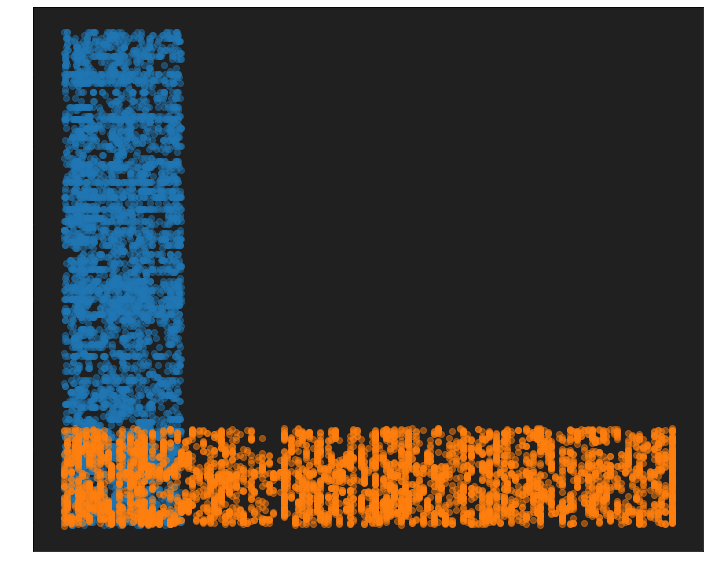

In [51]:
plt.figure(figsize=(12,10))

plt.scatter(test_data['Time'], test_data['ID'], alpha=0.5, label='True')
plt.scatter(df_pred['ID'], df_pred['Time'], alpha=0.5, label='Predicted')

In [55]:
set(test_data['ID'].unique()) ^ set(df_pred['ID'].unique())

{58, 166}

In [61]:
max(list(stoi.values()))

167

In [64]:
freq_true

,count


In [81]:
len(test_data[test_data['ID'] == 57].groupby(['ID']).size())

1

In [69]:
freq_true

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
ID,,,,,,,,,,,,,,,,,,,,,
0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN
160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN
161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN


In [71]:
freq_true

[ID
 0    13
 dtype: int64,
 ID
 1    59
 dtype: int64,
 ID
 2    54
 dtype: int64,
 ID
 3    15
 dtype: int64,
 ID
 4    72
 dtype: int64,
 ID
 5    10
 dtype: int64,
 ID
 6    23
 dtype: int64,
 ID
 7    25
 dtype: int64,
 ID
 8    52
 dtype: int64,
 ID
 9    49
 dtype: int64,
 ID
 10    20
 dtype: int64,
 ID
 11    30
 dtype: int64,
 ID
 12    40
 dtype: int64,
 ID
 13    36
 dtype: int64,
 Series([], dtype: int64),
 ID
 15    29
 dtype: int64,
 ID
 16    15
 dtype: int64,
 ID
 17    31
 dtype: int64,
 ID
 18    51
 dtype: int64,
 ID
 19    21
 dtype: int64,
 ID
 20    38
 dtype: int64,
 ID
 21    30
 dtype: int64,
 ID
 22    124
 dtype: int64,
 ID
 23    20
 dtype: int64,
 ID
 24    70
 dtype: int64,
 ID
 25    17
 dtype: int64,
 ID
 26    82
 dtype: int64,
 ID
 27    6
 dtype: int64,
 ID
 28    18
 dtype: int64,
 ID
 29    32
 dtype: int64,
 ID
 30    44
 dtype: int64,
 ID
 31    77
 dtype: int64,
 ID
 32    30
 dtype: int64,
 ID
 33    16
 dtype: int64,
 ID
 34    38
 dtype: int6

In [86]:
len(freq_true)
len(freq_pred)

166

In [113]:
df_pred = pd.read_csv("OneCombo3/inference/model_weighted_shuffle:True_perceiver_2.0_dt:0.05_eos_8_8_256.csv").iloc[:, 1:]
# df_pred['Trial'] = test_data['Trial']
df_pred.rename({'id':'ID', 'trial':'Trial', 'interval':'Interval', 'time':'Time'}, axis=1, inplace=True)
df_pred.head()


,ID,Time,Trial,Interval
0,0,0.00,0,0.0
1,128,0.20,2,0.5
2,13,0.45,2,0.5
3,166,0.55,2,0.5
4,104,0.05,2,1.0


In [114]:
df_pred

,ID,Time,Trial,Interval
0,0,0.00,0,0.0
1,128,0.20,2,0.5
2,13,0.45,2,0.5
3,166,0.55,2,0.5
4,104,0.05,2,1.0
...,...,...,...,...
5805,22,0.35,57,32.0
5806,166,0.40,57,32.0
5807,146,0.40,57,32.0
5808,151,0.45,57,32.0


In [115]:
df['Trials']

KeyError: 'Trials'

In [136]:
n_neurons = len(train_data['ID'].unique())

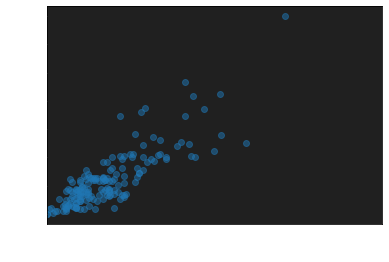

In [144]:
def get_freqs(df, n_neurons):
    freqs = np.zeros(n_neurons)
    for i in range(n_neurons):
        freqs[i] = (len(df[df['ID'] == i]))
    return freqs

freq_true = get_freqs(test_data, n_neurons)
freq_pred = get_freqs(df_pred[df_pred['ID'] <= max(test_data['ID'].unique())], n_neurons)

plt.xlabel('True Frequency (N)')
plt.ylabel('Predicted Frequency (N)')
plt.xlim(0, max(freq_pred))
plt.scatter(freq_true, freq_pred, alpha=0.5)

In [145]:
np.random.choice(df['Trial'].unique())

45

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

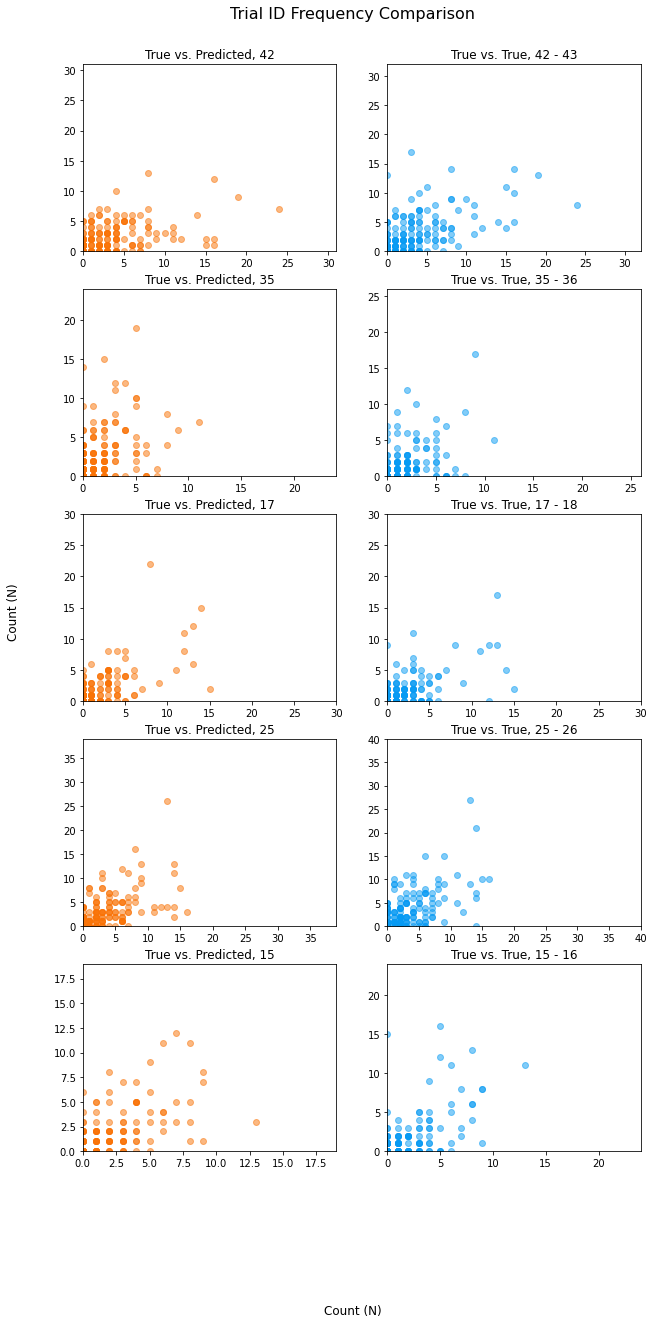

In [173]:
from utils import *

set_plot_white()

true_color = "#069AF3"
pred_color = "#F97306"
train_color = "#008000"


df_pred = df_pred[df_pred['ID'] <= max(test_data['ID'].unique())]

n_trials =
fig, ax = plt.subplots(figsize=(10, 20), nrows=n_trials, ncols=2)

neuron_ids = [i for i in range(20, 26)]
for i in range(neuron_ids):
    chosen_trial = np.random.choice(common_trials)
    freq_true = get_freqs(test_data[test_data['Trial'] == chosen_trial], n_neurons)
    freq_pred = get_freqs(df_pred[df_pred['Trial'] == chosen_trial], n_neurons)
    freq_train = get_freqs(train_data[train_data['Trial'] == chosen_trial + 1], n_neurons)

    ax[i, 0].set_title(f"True vs. Predicted, {chosen_trial}")
    ax[i, 0].scatter(freq_true, freq_pred, alpha=0.5, color=pred_color)
    ax[i, 0].set_xlim(0, max(freq_pred + freq_true))
    ax[i, 0].set_ylim(0, max(freq_pred + freq_true))

    ax[i, 1].set_title(f"True vs. True, {chosen_trial} - {chosen_trial + 1}")
    ax[i, 1].scatter(freq_true, freq_train, alpha=0.5, color=true_color)
    ax[i, 1].set_xlim(0, max(freq_train + freq_true))
    ax[i, 1].set_ylim(0, max(freq_train + freq_true))

    common_trials.remove(chosen_trial)


fig.supxlabel('Count (N)')
fig.supylabel('Count (N)')
fig.suptitle("Trial ID Frequency Comparison", y=0.92, fontsize=16)
plt.tight_layout

ValueError: x and y must be the same size

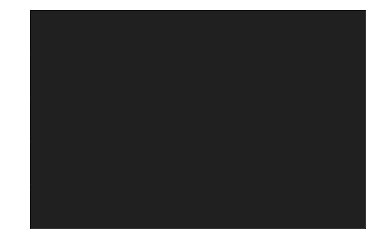

In [52]:
freq_true = test_data.groupby(['ID']).size()
freq_pred = df_pred.groupby(['ID']).size()
plt.scatter(freq_true, freq_pred, alpha=0.5)

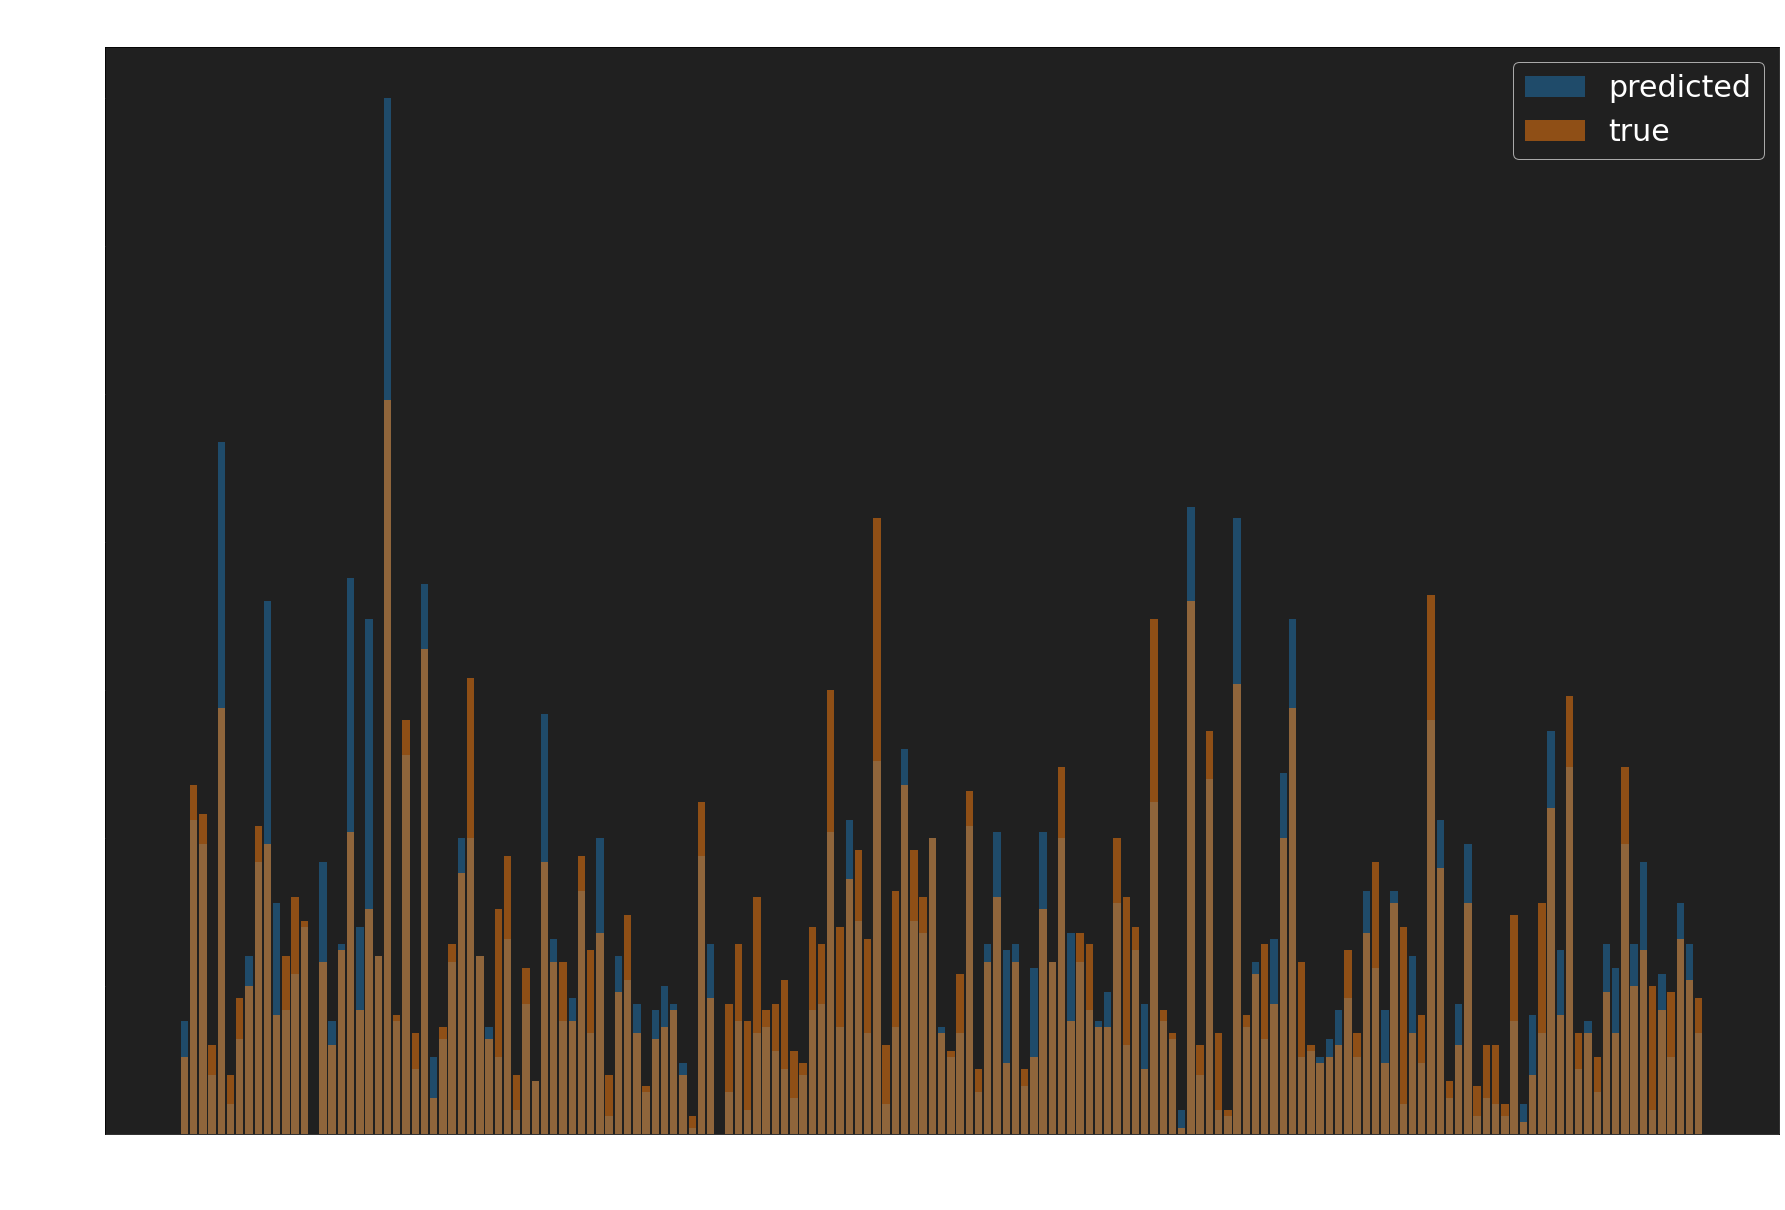

In [117]:
def plot_distribution(df_1, df_2):
    plt.figure(figsize=(30,20))
    n_min = 166
    freq_true = df_1[df_1['ID'] < n_min].groupby(['ID']).size()
    freq_pred = df_2[df_2['ID'] < n_min].groupby(['ID']).size()
    plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
    plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
    plt.title('Neuron Firing Distribution', fontsize=40)
    plt.legend(fontsize=30)
    plt.xlabel('Neuron ID (n)', fontsize=30)
    plt.ylabel('Count (N)', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.savefig("id_interval_dist.png", dpi=300)
    plt.show()


plot_distribution(test_data, df_pred)
# plt.savefig("id_interval_dist.png", dpi=300)

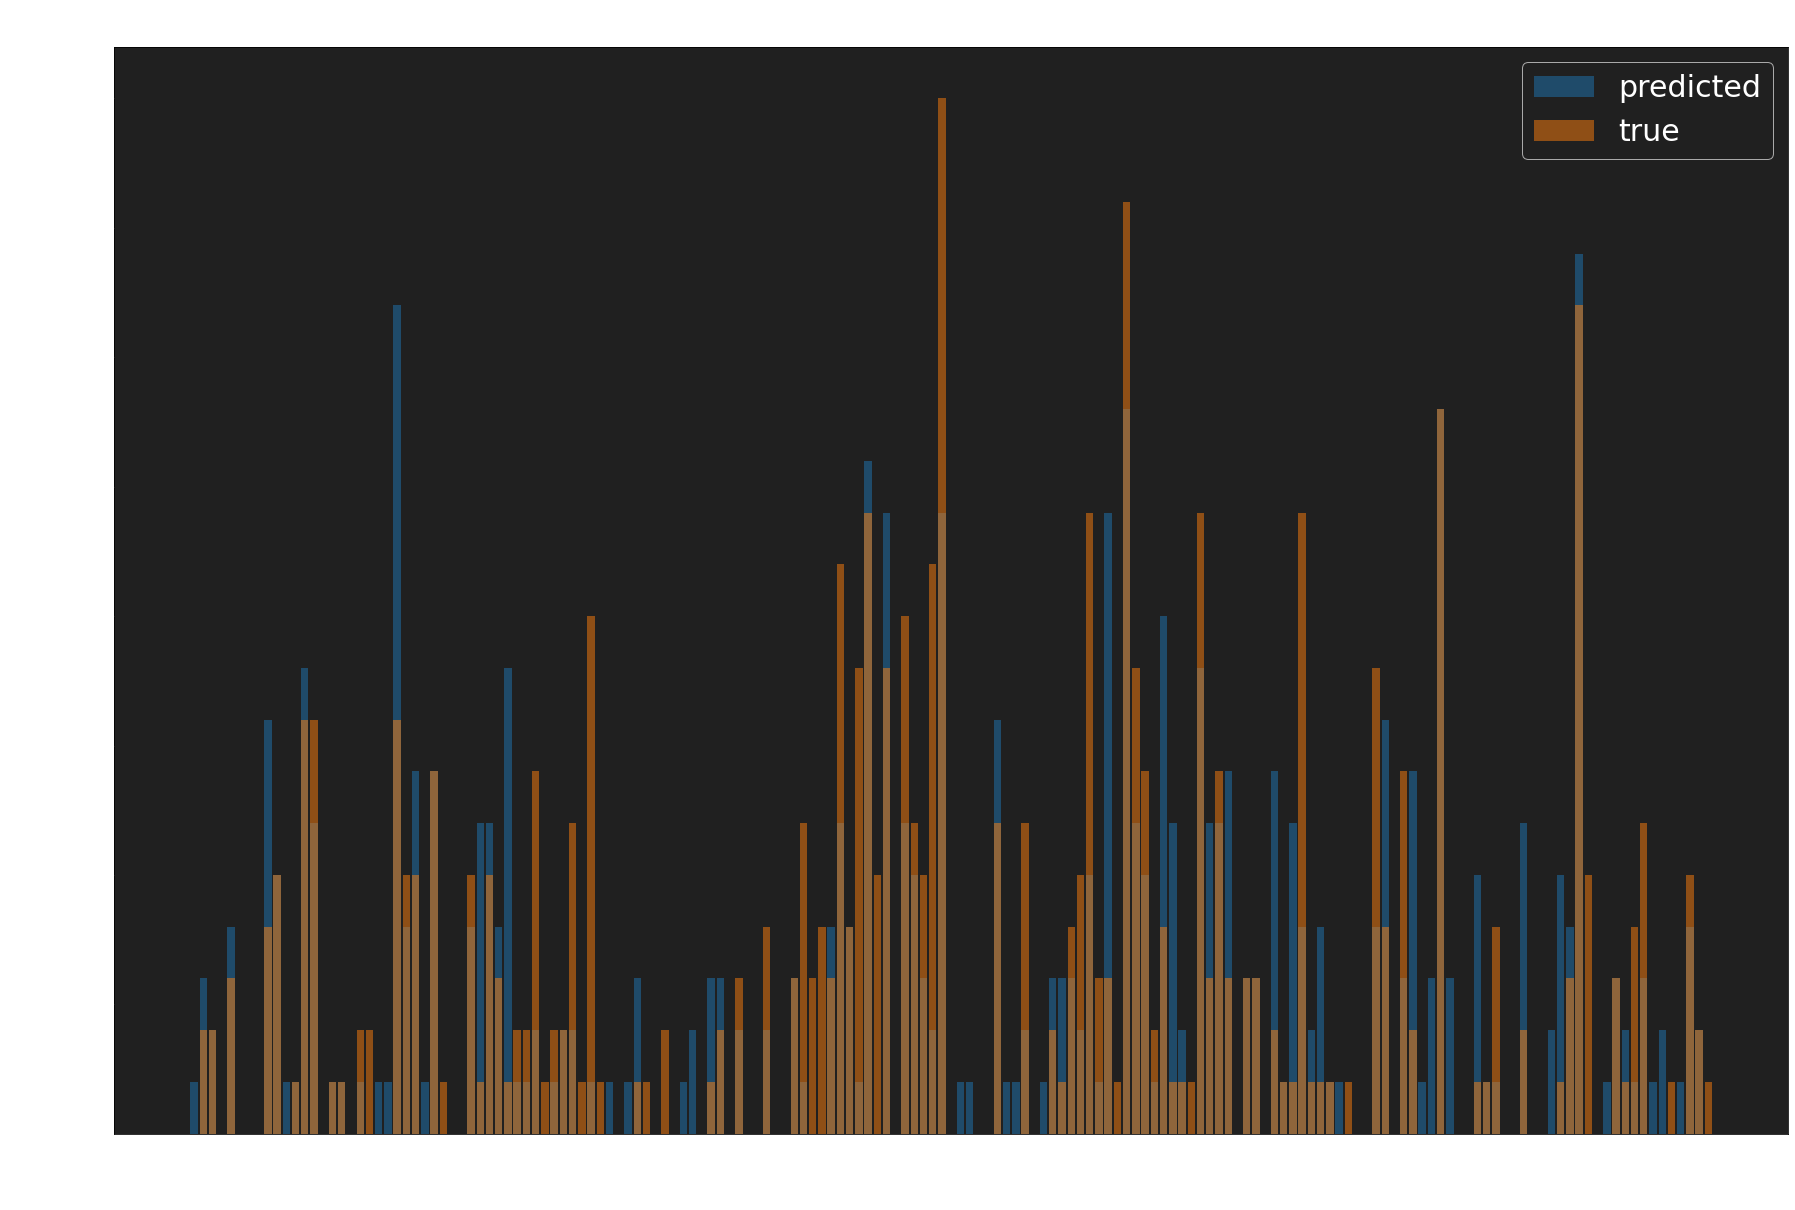

In [43]:
plot_distribution(df[df['Trial'] == 1], df[df['Trial'] == 2])

In [28]:
true_timing = np.array(true_timing)
predicted_timing = np.array(predicted_timing)
true_time_seq = [sum(true_timing[0:i[0]]) for i in enumerate(true_timing)]
pred_time_seq = [sum(predicted_timing[0:i[0]]) for i in enumerate(predicted_timing)]

NameError: name 'true_timing' is not defined

In [29]:
df_pred

,ID,dt,Trial,interval,Time
0,0,0.00,0,0.0,-0.500000
1,110,0.10,2,0.5,0.100000
2,23,0.15,2,0.5,0.150000
3,101,0.20,2,0.5,0.200000
4,71,0.25,2,0.5,0.250000
...,...,...,...,...,...
4153,16,0.20,57,32.0,31.700001
4154,25,0.30,57,32.0,31.799999
4155,106,0.35,57,32.0,31.849998
4156,86,0.40,57,32.0,31.900002


01/29/2022 19:48:35 - WARNING - matplotlib.font_manager -   findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
01/29/2022 19:48:35 - WARNING - matplotlib.font_manager -   findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu


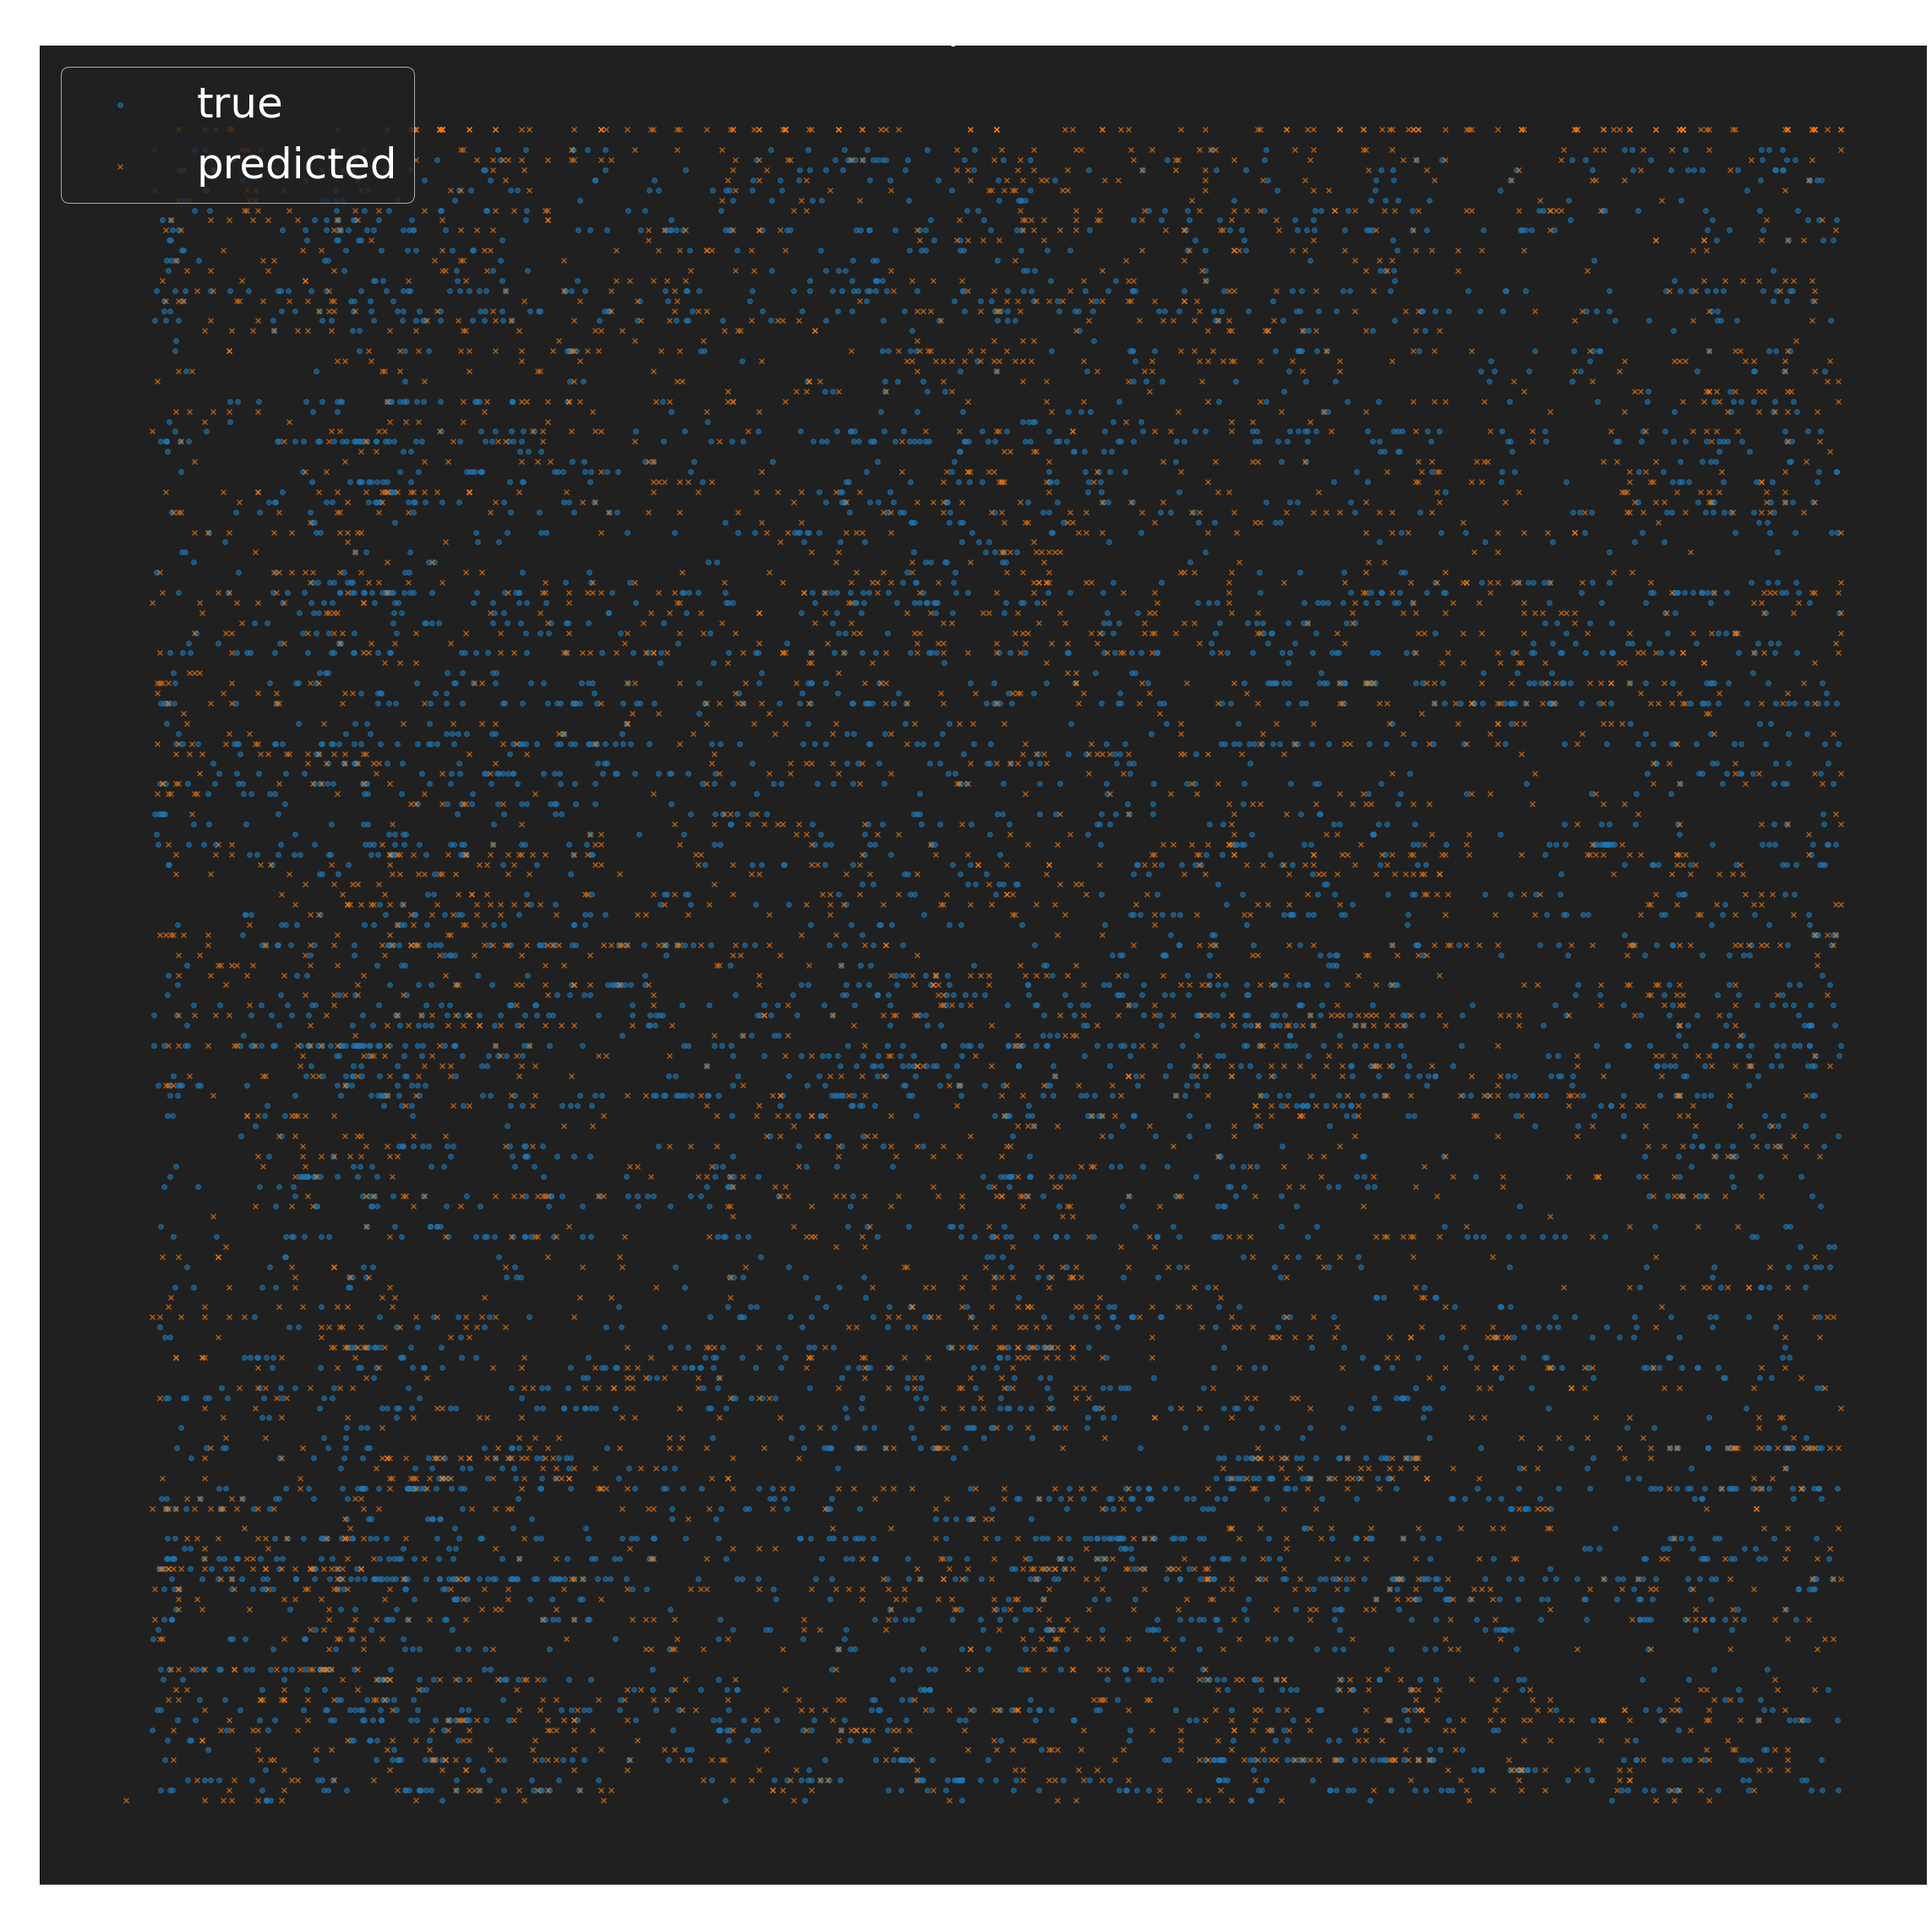

In [30]:
len_pred = len(df_true)
# len_pred = 1000
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(test_data['Time'], test_data['ID'], alpha=0.6, label='true', marker='o')
plt.scatter(df_pred['Time'], df_pred['ID'], alpha=0.6, label='predicted', marker='x')
plt.legend(fontsize=50)

In [ ]:
len_pred = len(true)
# len_pred = 1000
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(np.arange(len_pred), true[:len_pred], alpha=0.6, label='true', marker='o')
plt.scatter(np.arange(len_pred), predicted[:len_pred], alpha=0.6, label='predicted', marker='x')
plt.legend(fontsize=50)

In [ ]:
df_pred['Predicted_Time']

In [ ]:
np.arange(len(freq_dt_true.index))

In [ ]:
predicted_timing = [itos_dt for dt in predicted_timing]

In [ ]:
true_timing = pd.DataFrame(true_timing)
predicted_timing = pd.DataFrame(predicted_timing)
plot_distribution(true_timing[true_timing[0] > 0], predicted_timing[predicted_timing[0] > 0])